In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import yfinance
import ta

# Import data

In [9]:
df = yfinance.Ticker('EURUSD=X').history(period='5y')[['Open', 'High', 'Low', 'Close']]
df.head()

,Open,High,Low,Close
Date,,,,
2015-11-24,1.063898,1.067201,1.062383,1.064203
2015-11-25,1.064396,1.069000,1.057600,1.064385
2015-11-26,1.062496,1.063000,1.060200,1.062496
2015-11-27,1.060445,1.063800,1.057000,1.060445
2015-11-30,1.058302,1.059704,1.056400,1.058302


In [10]:
df.describe()

,Open,High,Low,Close
count,1303.000000,1303.000000,1303.000000,1303.000000
mean,1.133185,1.136652,1.129769,1.133214
std,0.043852,0.043965,0.043750,0.043846
min,1.039393,1.041992,1.034768,1.039047
25%,1.103357,1.106853,1.100494,1.103217
50%,1.126126,1.130000,1.123280,1.126152
75%,1.166541,1.170487,1.163149,1.166589
max,1.251267,1.255808,1.245051,1.251001


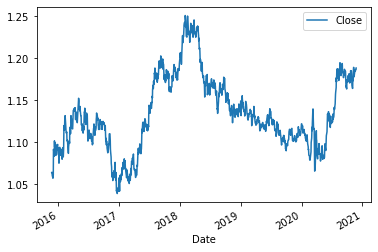

In [11]:
df.plot(y='Close')

## Fill NaN

In [12]:
df = df.ffill()

In [13]:
df['return'] = df['Close'].shift(-1) - df['Close']

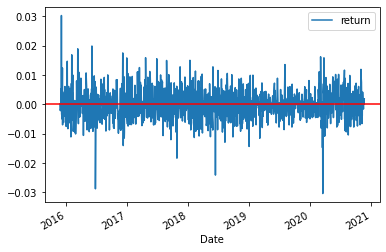

In [14]:
df.plot(y='return')
plt.axhline(0, color='red')

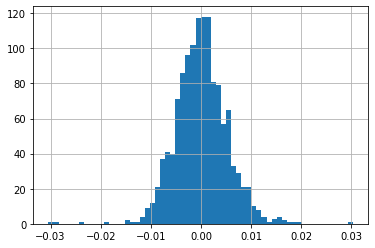

In [15]:
df['return'].hist(bins=60)

## Buy & Sell by MACD

In [62]:
df['fast_signal'] = df['Close'].rolling(10).mean()
df['slow_signal'] = df['Close'].rolling(30).mean()
df['macd'] = ta.trend.MACD(df['Close']).macd()
# df['response'] = df['fast_signal'] > df['slow_signal']
df['response'] = df['macd'] > 0
df['margin'] = df['return'] * df['response']
present_df = df.loc['2018-01-01':]

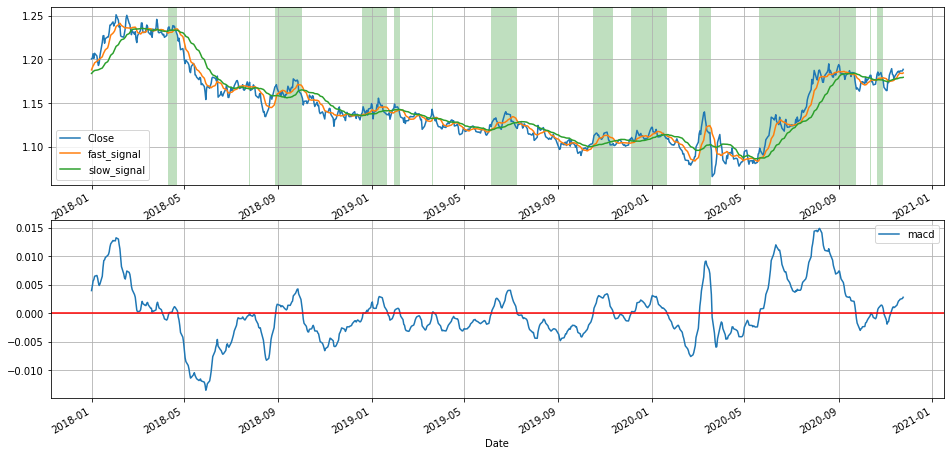

In [63]:

    
start_indices = np.argwhere((present_df['response'] == False).to_numpy() & (present_df['response'].shift(-1) == True).to_numpy())
start_indices = np.squeeze(start_indices)
stop_indices = np.argwhere((present_df['response'] == True).to_numpy() & (present_df['response'].shift(-1) == False).to_numpy())
stop_indices = np.squeeze(stop_indices)

fig, axes = plt.subplots(2, figsize=(16, 16))
present_df.plot(y=['Close', 'fast_signal', 'slow_signal'], figsize=(16, 8), grid=True, ax=axes[0])
present_df.plot(y='macd', figsize=(16, 8), grid=True, ax=axes[1])
axes[1].axhline(0, color='red')

if start_indices[0] > stop_indices[0]:
    stop_indices = stop_indices[1:]
if start_indices[-1] > stop_indices[-1]:
    start_indices = start_indices[:-1]
# if start_indices[-1] < stop_indices[-1]


for start, stop in zip(start_indices, stop_indices):
    
    start_value = present_df['Close'].values[start]
    stop_value = present_df['Close'].values[stop]
    if start_value < stop_value:
        color = 'green'
    else:
        color = 'red'
    y_min = min(start_value, stop_value)
    y_max = max(start_value, stop_value)

#     plt.fill_between(present_df.index[start: stop], present_df['Close'].values[start: stop], y_min, color=color)
    axes[0].axvspan(present_df.index[start], present_df.index[stop], facecolor='green', alpha=0.25)
    

In [64]:
profit = 0
for buy_time, sell_time in zip(start_indices, stop_indices):
#     profit += present_df.iloc[buy_time]
    buy_value, sell_value = present_df['Close'].values[[buy_time, sell_time]]
    profit += sell_value - buy_value

<ipython-input-65-09a538243123>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  present_df['action'] = 0
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-65-09a538243123>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  present_df['action'].iloc[buy_time] = 

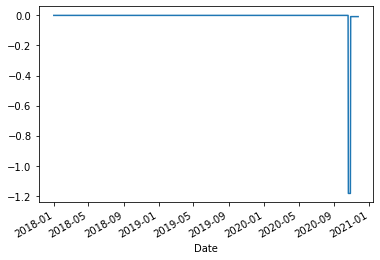

In [65]:
present_df['action'] = 0
present_df['action'].iloc[buy_time] = -1
present_df['action'].iloc[sell_time] = 1
present_df['action'] = present_df['action'] * present_df['Close']
present_df['action'].cumsum().plot()

,Open,High,Low,Close,return,fast_signal,slow_signal,response,margin,macd,action
Date,,,,,,,,,,,
2019-01-01,1.149425,1.155001,1.146500,1.149306,-0.003135,1.141394,1.137572,True,-0.003135,0.001706,0
2019-01-02,1.146132,1.149700,1.134572,1.146171,-0.014361,1.142257,1.137869,True,-0.014361,0.001978,0
2019-01-03,1.131734,1.140914,1.131734,1.131811,0.007297,1.141543,1.137635,True,0.007297,0.001024,0
2019-01-04,1.139095,1.141774,1.134816,1.139108,0.001937,1.140885,1.137595,True,0.001937,0.000847,0
2019-01-07,1.141292,1.147447,1.140524,1.141044,0.006929,1.141262,1.137838,True,0.006929,0.000852,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,1.186437,1.189100,1.185115,1.186366,-0.001602,1.182414,1.178340,True,-0.001602,0.002146,0
2020-11-19,1.184287,1.185536,1.181740,1.184764,0.001884,1.183564,1.178607,True,0.001884,0.002245,0
2020-11-20,1.186746,1.189089,1.185185,1.186648,0.000000,1.184053,1.178938,True,0.000000,0.002447,0


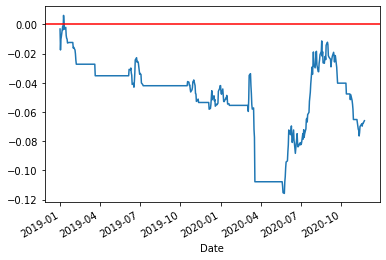

In [47]:
present_df['margin'].cumsum().plot()
plt.axhline(0, color='red')